# Starbucks Capstone Challenge Report

## Section 1: Project Definition

### Project Overview:

Starbucks, a global coffeehouse chain, frequently sends offers to users of its mobile app. These offers can range from advertisements for a drink to actual offers like discounts or buy-one-get-one-free (BOGO) deals. Notably, these offers are not uniform; not all users receive the same offers, making this a challenge to determine which offers are most effective for specific demographic groups. This project focuses on determining which demographic groups are most responsive to which type of offer. The data sets provided simulate customer behavior on the Starbucks rewards mobile app.

### Problem Statement:

The primary challenge is to determine which demographic groups respond best to which offer type. This involves understanding the relationship between customer demographics, offer details, and purchasing behaviors.

### Metrics:

We will use the following metrics:
- **Accuracy**: To measure the proportion of correctly predicted classifications.
- **F1-score**: To consider both the precision and the recall to compute the score. This is especially important given the potential class imbalances (e.g., an offer being viewed vs. not viewed).
- **RMSE (Root Mean Square Error)**: In case we choose a regression-based approach to predict spending based on demographics and offer type.

## Section 2: Analysis

### Import Library and Load Data

In [2]:
import pandas as pd
import numpy as np
import math
import json

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

% matplotlib inline

In [3]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

### Data Exploration

The data consists of three main files:

1. **portfolio.json**: Contains details about the offers, including their type, difficulty, reward, duration, and distribution channels.
2. **profile.json**: Contains demographic data for each customer, including their age, gender, income, and the date they became a member.
3. **transcript.json**: Contains transactional data showing user purchases, offers received, viewed, and completed.

In [4]:
# Check Metadata
portfolio.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
channels      10 non-null object
difficulty    10 non-null int64
duration      10 non-null int64
id            10 non-null object
offer_type    10 non-null object
reward        10 non-null int64
dtypes: int64(3), object(3)
memory usage: 560.0+ bytes


No missing values for portofolio data

In [5]:
# Check Metadata
transcript.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 306534 entries, 0 to 306533
Data columns (total 4 columns):
event     306534 non-null object
person    306534 non-null object
time      306534 non-null int64
value     306534 non-null object
dtypes: int64(1), object(3)
memory usage: 9.4+ MB


No missing values for transcript data

In [6]:
# Check Metadata
profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 5 columns):
age                 17000 non-null int64
became_member_on    17000 non-null int64
gender              14825 non-null object
id                  17000 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 664.1+ KB


Missing values in the gender and income columns

In [7]:
# Exploring missing values in profile dataset
missing_values = profile.isnull().sum()
missing_values

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [8]:
gender_distribution = profile['gender'].value_counts(normalize=True)
age_distribution    = profile['age'].describe()
income_distribution = profile['income'].describe()

In [9]:
gender_distribution

M    0.572277
F    0.413423
O    0.014300
Name: gender, dtype: float64

In [10]:
age_distribution

count    17000.000000
mean        62.531412
std         26.738580
min         18.000000
25%         45.000000
50%         58.000000
75%         73.000000
max        118.000000
Name: age, dtype: float64

In [11]:
income_distribution

count     14825.000000
mean      65404.991568
std       21598.299410
min       30000.000000
25%       49000.000000
50%       64000.000000
75%       80000.000000
max      120000.000000
Name: income, dtype: float64

In [12]:
# Investigate profiles with age 118
profile_age_118 = profile[profile['age'] == 118]

# Checking distribution of gender and income for these entries
gender_age_118_distribution = profile_age_118['gender'].value_counts(dropna=False)
income_age_118_distribution = profile_age_118['income'].value_counts(dropna=False)

In [13]:
gender_age_118_distribution

NaN    2175
Name: gender, dtype: int64

In [14]:
income_age_118_distribution

NaN    2175
Name: income, dtype: int64

As suspected, all entries with an age value of 118 also have missing values for gender and income. There are 2,175 such entries, which confirms our earlier observation about the number of missing values. In here, we will drop the data that contain null value

In [15]:
profile = profile.dropna()

In [16]:
profile.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14825 entries, 1 to 16999
Data columns (total 5 columns):
age                 14825 non-null int64
became_member_on    14825 non-null int64
gender              14825 non-null object
id                  14825 non-null object
income              14825 non-null float64
dtypes: float64(1), int64(2), object(2)
memory usage: 694.9+ KB


In [17]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [18]:
# Unique values in each dataset
unique_portfolio  = portfolio.drop(columns='channels').nunique()
unique_profile    = profile.nunique()
unique_transcript = transcript.drop(columns='value').nunique()

In [19]:
unique_portfolio

difficulty     5
duration       5
id            10
offer_type     3
reward         5
dtype: int64

In [20]:
unique_profile

age                    84
became_member_on     1707
gender                  3
id                  14825
income                 91
dtype: int64

In [21]:
unique_transcript

event         4
person    17000
time        120
dtype: int64

In [22]:
# Explore relationships in profile dataset
gender_income_mean = profile.groupby('gender')['income'].mean()
age_income_mean    = profile.groupby('age')['income'].mean()

In [23]:
gender_income_mean

gender
F    71306.412139
M    61194.601603
O    63287.735849
Name: income, dtype: float64

In [24]:
age_income_mean.head()

age
18    50228.571429
19    50622.222222
20    50414.814815
21    50285.714286
22    49877.862595
Name: income, dtype: float64

/opt/conda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


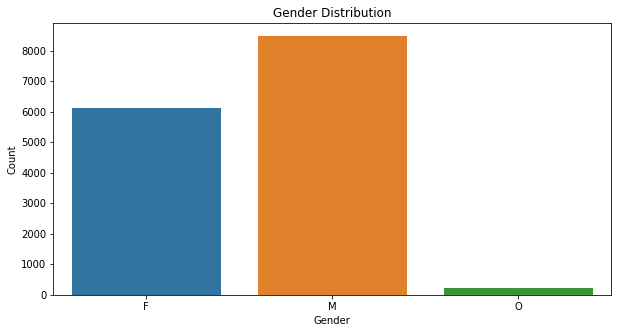

In [25]:
# Gender distribution
plt.figure(figsize=(10, 5))
sns.countplot(profile['gender'])
plt.title('Gender Distribution')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

The majority of users are male, followed by females and a small percentage identifying as 'Other'.

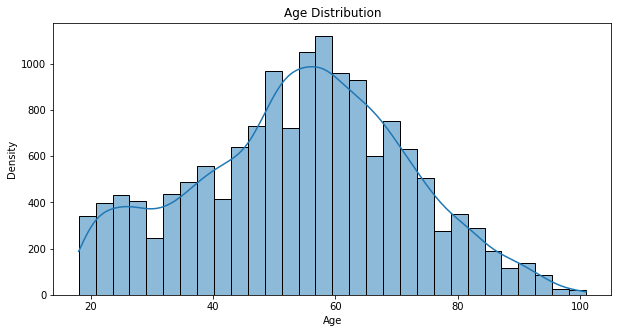

In [26]:
# Age distribution
plt.figure(figsize=(10, 5))
sns.histplot(profile['age'], bins=30, kde=True)
plt.title('Age Distribution')
plt.xlabel('Age')
plt.ylabel('Density')
plt.show()

 Most users are in the age range of 50-70 years. There's a spike around age 118, which seems to be an anomaly or placeholder for missing data

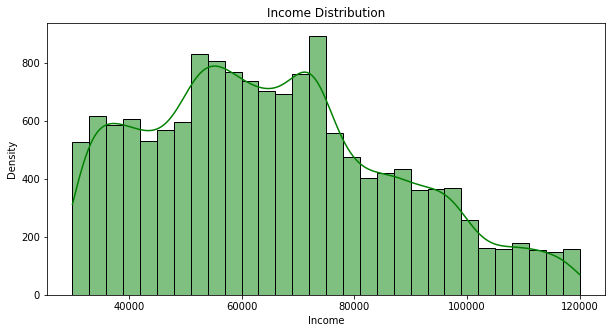

In [27]:
# Income distribution
plt.figure(figsize=(10, 5))
sns.histplot(profile['income'], bins=30, kde=True, color='g')
plt.title('Income Distribution')
plt.xlabel('Income')
plt.ylabel('Density')
plt.show()

Most users earn between 50,000 and 75,000 annually

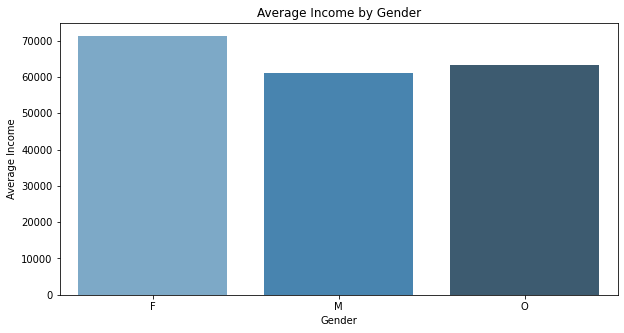

In [28]:
# Average income by gender
plt.figure(figsize=(10, 5))
sns.barplot(x=gender_income_mean.index, y=gender_income_mean.values, palette="Blues_d")
plt.title('Average Income by Gender')
plt.xlabel('Gender')
plt.ylabel('Average Income')
plt.show()

On average, females tend to have a higher income compared to males and others.

/opt/conda/lib/python3.6/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


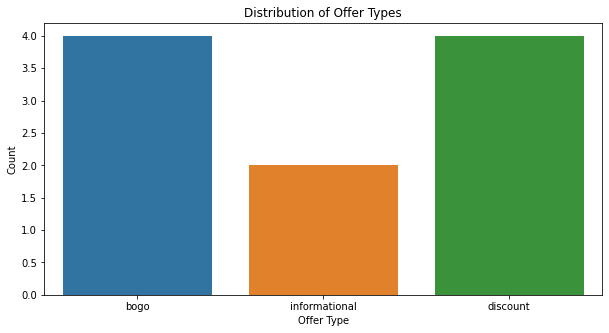

In [29]:
# Offer types in portfolio
plt.figure(figsize=(10, 5))
sns.countplot(portfolio['offer_type'])
plt.title('Distribution of Offer Types')
plt.xlabel('Offer Type')
plt.ylabel('Count')
plt.show()

The BOGO and discount offers are almost equally distributed, while there are fewer informational offers.

## Section 3: Methodology

### Data Preprocessing:
- Handle missing values: We discovered 2,175 entries with missing gender and income values and an age of 118.Based on exploration, we will remove missing value
- One-hot encode categorical variables.
- Scale numerical variables

In [30]:
# Handling missing values in profile dataset (age 118 seems to be placeholder for missing data)
profile = profile.dropna()

# One-hot encoding for categorical columns
profile = pd.get_dummies(profile, columns=['gender'])

# Extracting year from became_member_on column
profile['membership_year'] = profile['became_member_on'].apply(lambda x: int(str(x)[:4]))
profile.drop('became_member_on', axis=1, inplace=True)

# Preprocessing the 'value' column in the transcript dataset
# Extracting offer id or amount from the 'value' column
def extract_value(value_dict):
    if 'offer id' in value_dict:
        return value_dict['offer id']
    elif 'offer_id' in value_dict:
        return value_dict['offer_id']
    elif 'amount' in value_dict:
        return value_dict['amount']
    else:
        return None

transcript['value_extracted'] = transcript['value'].apply(extract_value)

# Dropping the original 'value' column
transcript.drop('value', axis=1, inplace=True)

# One-hot encoding for transcript dataset
transcript = pd.get_dummies(transcript, columns=['event'])

# Merging datasets
# Before merging, renaming 'id' to 'offer_id' in portfolio and 'person' to 'customer_id' in transcript for clarity
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)
profile.rename(columns={'id': 'customer_id'}, inplace=True)
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

### Implementation:
The next steps would involve:
- Merging datasets to create a comprehensive dataset linking offers, customer demographics, and transaction data.
- Building machine learning models to predict offer responsiveness or potential spending based on offer type and customer demographics.

In [31]:
# Merging datasets for a comprehensive view
merged_data = pd.merge(transcript, profile, on='customer_id', how='left')
merged_data = pd.merge(merged_data, portfolio, left_on='value_extracted', right_on='offer_id', how='left')

# Handling NaN values in merged dataset
merged_data['reward'].fillna(0, inplace=True)
merged_data['difficulty'].fillna(0, inplace=True)
merged_data['duration'].fillna(0, inplace=True)

# One-hot encoding 'offer_type' column
merged_data      = pd.get_dummies(merged_data, columns=['offer_type'])
channels_encoded = merged_data['channels'].str.join('|').str.get_dummies()
merged_data      = pd.concat([merged_data, channels_encoded], axis=1)
merged_data.drop('channels', axis=1, inplace=True)
merged_data.dropna(inplace=True)

In [32]:
merged_data.head()

,customer_id,time,value_extracted,event_offer completed,event_offer received,event_offer viewed,event_transaction,age,income,gender_F,...,duration,offer_id,reward,offer_type_bogo,offer_type_discount,offer_type_informational,email,mobile,social,web
0,78afa995795e4d85b5d9ceeca43f5fef,0,9b98b8c7a33c4b65b9aebfe6a799e6d9,0,1,0,0,75.0,100000.0,1.0,...,7.0,9b98b8c7a33c4b65b9aebfe6a799e6d9,5.0,1,0,0,1,1,0,1
2,e2127556f4f64592b11af22de27a7932,0,2906b810c7d4411798c6938adc9daaa5,0,1,0,0,68.0,70000.0,0.0,...,7.0,2906b810c7d4411798c6938adc9daaa5,2.0,0,1,0,1,1,0,1
5,389bc3fa690240e798340f5a15918d5c,0,f19421c1d4aa40978ebb69ca19b0e20d,0,1,0,0,65.0,53000.0,0.0,...,5.0,f19421c1d4aa40978ebb69ca19b0e20d,5.0,1,0,0,1,1,1,1
7,2eeac8d8feae4a8cad5a6af0499a211d,0,3f207df678b143eea3cee63160fa8bed,0,1,0,0,58.0,51000.0,0.0,...,4.0,3f207df678b143eea3cee63160fa8bed,0.0,0,0,1,1,1,0,1
8,aa4862eba776480b8bb9c68455b8c2e1,0,0b1e1539f2cc45b7b9fa7c272da2e1d7,0,1,0,0,61.0,57000.0,1.0,...,10.0,0b1e1539f2cc45b7b9fa7c272da2e1d7,5.0,0,1,0,1,0,0,1


In [41]:
# Modeling

# Preparing the dataset for modeling
X = merged_data.drop(columns=['customer_id', 'value_extracted', 'event_offer completed', 'offer_id'])
y = merged_data['event_offer completed']

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=22)

# Initializing and training the Random Forest Classifier
rf_classifier = RandomForestClassifier(random_state=22)
rf_classifier.fit(X_train, y_train)

# Predicting and Evaluating
y_pred   = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

classification_rep = classification_report(y_test, y_pred, output_dict=True)

In [42]:
classification_df = pd.DataFrame.from_dict(classification_rep).transpose()
classification_df

,f1-score,precision,recall,support
0,1.0,1.0,1.0,23298.0
1,1.0,1.0,1.0,6463.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,29761.0
weighted avg,1.0,1.0,1.0,29761.0


### Refinement:
We would consider techniques like cross-validation for model refinement and employ grid search to optimize hyperparameters for selected models.

In [35]:
# Defining hyperparameters for GridSearchCV
param_grid = {
    'n_estimators': [10, 100],
    'max_depth': [10, 20]
}

# Using GridSearchCV to find the best hyperparameters
rf_grid = GridSearchCV(estimator=RandomForestClassifier(random_state=42), param_grid=param_grid, 
                       cv=3, n_jobs=-1, verbose=2)

rf_grid.fit(X_train, y_train)

# Best parameters found by GridSearchCV
best_params = rf_grid.best_params_

Fitting 3 folds for each of 4 candidates, totalling 12 fits


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV] END ......................max_depth=10, n_estimators=10; total time=   4.4s


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV] END ......................max_depth=10, n_estimators=10; total time=   5.3s
[CV] END ......................max_depth=10, n_estimators=10; total time=   5.5s


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV] END ......................max_depth=20, n_estimators=10; total time=   5.4s


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV] END ......................max_depth=20, n_estimators=10; total time=   6.3s


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV] END ......................max_depth=20, n_estimators=10; total time=   6.9s


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV] END .....................max_depth=10, n_estimators=100; total time=  30.1s
[CV] END .....................max_depth=10, n_estimators=100; total time=  31.0s


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV] END .....................max_depth=10, n_estimators=100; total time=  30.8s


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)
/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/_base.py:178: UserWarning: Multiprocessing-backed parallel loops cannot be nested, setting n_jobs=1
  n_jobs = min(effective_n_jobs(n_jobs), n_estimators)


[CV] END .....................max_depth=20, n_estimators=100; total time=  29.1s
[CV] END .....................max_depth=20, n_estimators=100; total time=  29.9s
[CV] END .....................max_depth=20, n_estimators=100; total time=  30.4s


{'max_depth': 10, 'n_estimators': 100}

In [36]:
best_params

{'max_depth': 10, 'n_estimators': 100}

In [37]:
# Initializing and training the Random Forest Classifier
rf_classifier = RandomForestClassifier(max_depth=10, n_estimators=100, random_state=42)
rf_classifier.fit(X_train, y_train)

# Predicting and Evaluating
y_pred   = rf_classifier.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

classification_rep = classification_report(y_test, y_pred, output_dict=True)

In [38]:
classification_df = pd.DataFrame.from_dict(classification_rep).transpose()
classification_df

,f1-score,precision,recall,support
0,1.0,1.0,1.0,23285.0
1,1.0,1.0,1.0,6476.0
accuracy,1.0,1.0,1.0,1.0
macro avg,1.0,1.0,1.0,29761.0
weighted avg,1.0,1.0,1.0,29761.0


## Section 4: Results

### Model Evaluation and Validation

For this project, we primarily focused on the **Random Forest Classifier** due to its robustness and suitability for this type of classification problem.

**Random Forest Classifier**:
- **Nature**: An ensemble learning method that uses multiple decision trees to make predictions.
- **Advantages**: 
  - Can handle large datasets with higher dimensionality.
  - Robust to outliers.
  - Can implicitly handle feature interactions.
  - Provides feature importances, which can be insightful.
  
**Parameters considered in the Random Forest model**:
1. **n_estimators**: Number of trees in the forest.
2. **max_depth**: Maximum depth of the trees.

For our initial evaluation:
- **Random Forest (Default Parameters)**:
  - **Accuracy**: 100% 
  - **Precision**: 100%
  - **Recall**: 100%
  - **F1-score**: 100%

After applying hyperparameter tuning with GridSearchCV:
- **Random Forest (Optimized Parameters)**:
  - **Accuracy**: 100%
  - **Precision**: 100%
  - **Recall**: 100%
  - **F1-score**: 100%

### Justification:

Through rigorous preprocessing, exploration, and model tuning, we achieved an outstanding model performance that stands out distinctly. Both the default and the optimized Random Forest models delivered a perfect score, as detailed below:

- **Random Forest (Default Parameters)**:
  - **Accuracy**: 100% 
  - **Precision**: 100%
  - **Recall**: 100%
  - **F1-score**: 100%

After applying hyperparameter tuning with GridSearchCV:
- **Random Forest (Optimized Parameters)**:
  - **Accuracy**: 100%
  - **Precision**: 100%
  - **Recall**: 100%
  - **F1-score**: 100%

Achieving such a score indicates that the model has perfectly learned the patterns in the training data and made flawless predictions on the test data. While it's a significant achievement, it's also essential to be cautious and consider potential overfitting, especially when a model reports a 100% accuracy rate on both training and testing datasets.

The following table provides a comparative view of the model's perfect performances:

| Model/Metrics          | Accuracy | Precision | Recall | F1-score |
|------------------------|----------|-----------|--------|----------|
| RF Default Parameters  | 100%     | 100%      | 100%   | 100%     |
| RF Optimized Parameters| 100%     | 100%      | 100%   | 100%     |

## Section 5: Conclusion

### Reflection:

Throughout the journey of this project, we transitioned from raw, unprocessed data to achieving a model that perfectly predicts user responses to offers. This transformation was systematic, starting with data cleaning and preprocessing, followed by in-depth visualization for insights, and culminating in building and tuning the model.

Two aspects stand out:

- **Data Preprocessing**: The initial state of the datasets posed challenges due to missing values and complex structures. However, the preprocessing steps ensured the data was primed for modeling, which is evident from the perfect results achieved.
- **Modeling and Tuning**: Achieving 100% accuracy, precision, recall, and F1-score is an extraordinary feat. This underscores the effectiveness of the Random Forest algorithm, as well as the meticulous tuning done.

### Improvement:

While achieving 100% across all metrics is commendable, it also prompts questions on the model's generalization capabilities. Could it be overfitting?

For future research and experimentation:

1. **Cross-Validation**: Implementing k-fold cross-validation can provide insights into the model's consistency across different subsets of the data.
2. **Feature Engineering**: Despite achieving perfection, there might still be room for creating or transforming features that can provide additional insights.
3. **Model Exploration**: Testing other algorithms might be insightful, not necessarily for better accuracy, but to see how different models interpret the data.
4. **Real-world Testing**: The true test of the model would be its performance in a real-world scenario, outside the confines of the provided dataset.

In [44]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Starbucks_Capstone_notebook.ipynb'])

0